# 2024 Winter Introduction to Deep Learning
### Based on Prof. Oh's Youtube Lecture
https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M

> Assignment #8


*   Youtube Lecture #32-35
*   Written by Seungeun Lee

## 1. Autoencoder
*     Reference. https://dacon.io/codeshare/4551
*     FashionMNIST dataset

#### (1) Extract latent vectors & Reconstruct image w/ Autoencoder (AE)

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [2]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
trainset = datasets.FashionMNIST( # FashionMNIST 데이터를 불러오는 코드
    root      = './.data/',
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

In [4]:
class Autoencoder(nn.Module): # 오토인코더 모듈을 정의하는 클래스
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder (input: 28*28 image -> 3 as a latent vector)
        self.encoder = nn.Sequential( # 입력받은 이미지를 통해 latent vector를 만드는 encoder를 구축하는 코드이다.
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )
        # Decoder (from latent vector (size: 3) -> decode it to 28*28 size image)
        self.decoder = nn.Sequential( # latent vector를 이용하여 이미지를 재구성하는 decoder를 구축하는 코드이다.
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [5]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005) # 옵티마이저 선언
criterion = nn.MSELoss() # 오차 함수로 평균 제곱 오차를 사용

In [6]:
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [7]:
def train(autoencoder, train_loader): # 학습을 위한 함수
    autoencoder.train() # 학습용으로 전환하는 코드
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y) # 실제값과 디코딩하여 얻은 값을 비교하여 오차값을 계산
        optimizer.zero_grad() # 기울기 초기화
        loss.backward() # 기울기 계산
        optimizer.step() # 가중치 업데이트

[Epoch 1]


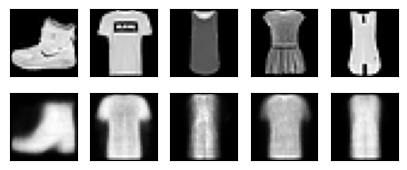

[Epoch 2]


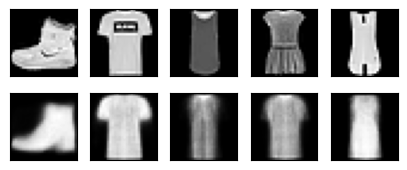

[Epoch 3]


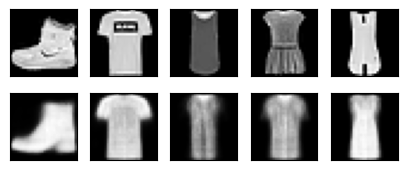

[Epoch 4]


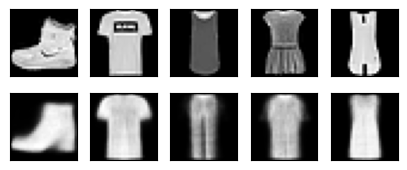

[Epoch 5]


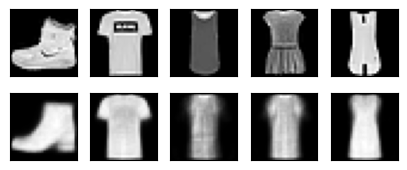

[Epoch 6]


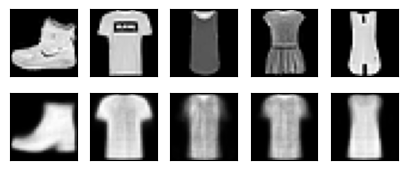

[Epoch 7]


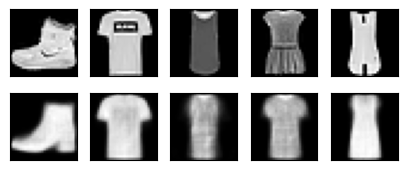

[Epoch 8]


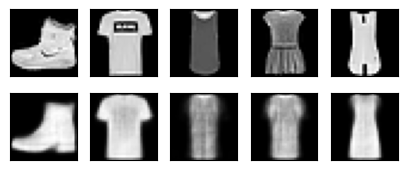

[Epoch 9]


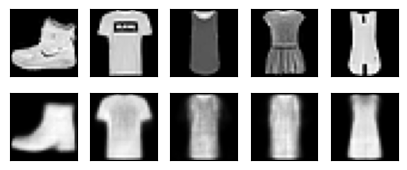

[Epoch 10]


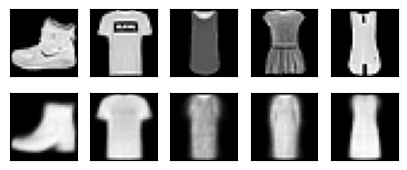

In [8]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

#### (2) Image Denoising w/ AE

In [9]:
def add_noise(img): # 입력 이미지에 잡음(noise)를 더하는 함수이다.
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [10]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        noisy_x = add_noise(x)
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    return avg_loss / len(train_loader)

In [11]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))

[Epoch 1] loss:0.023037862807099244
[Epoch 2] loss:0.022479442277871596
[Epoch 3] loss:0.022502934663439358
[Epoch 4] loss:0.022352210120923484
[Epoch 5] loss:0.022258085623653584
[Epoch 6] loss:0.02227766681581672
[Epoch 7] loss:0.022238153571100122
[Epoch 8] loss:0.021999692709159368
[Epoch 9] loss:0.022045440499239892
[Epoch 10] loss:0.022060750774157516


In [12]:
testset = datasets.FashionMNIST(
    root      = './.data/',
    train     = False, # Unseen test dataset
    download  = True,
    transform = transforms.ToTensor()
)

sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

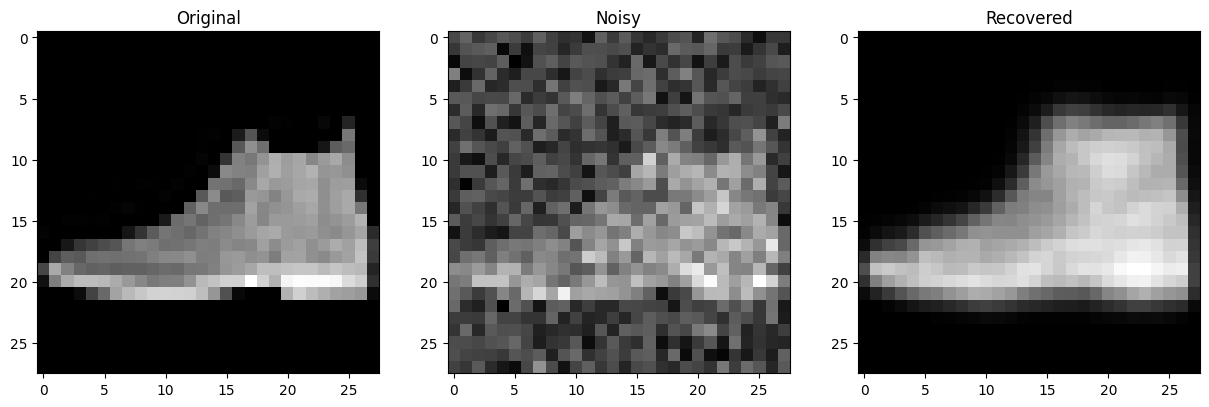

In [13]:
f, a = plt.subplots(1, 3, figsize=(15, 15))

original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# original image
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# original image w/ noise
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# recoveredimage
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

### Question 1. Explain the code of the '1. Autoencoder' section "briefly".

### 오토인코더란 어떠한 입력이 들어왔을 때, 해당 입력 데이터를 최대한 압축시킨 후, 데이터의 특징을 추출하여 다시 원래의 입력 형태로 복원시키는 신경망이다.
### 오토인코더는 크게 입력 데이터를 압축시키는 Encoder와 압축시킨 데이터를 원래 이미지와 비슷하도록 재구성 하는 Decoder 이루어져 있다.
### 오토인코더는 여러 방법으로 활용 되는데 다음과 같다.
#### 1. 차원축소 : 오토인코더를 이용하면 원래 주로 쓰던 차원축소 기법인 PCA보다 더 정확한 차원축소를 할 수 있다. (PCA는 데이터를 가장 잘 표현하는 "선"을 이용하여 데이터의 차원을 축소하는 기법이기에 선형적으로만 차원을 축소할 수 있다. 하지만, 오토인코더 비선형적으로도 차원축소가 가능하기에 PCA보다 시각화 및 성능이 더 뛰어나다.)
#### 2. 이상탐지 : 오토인코더는 훈련의 일부로 재구성 오류를 최소화하려는 성질이 있다. 따라서 재구성 손실의 크기를 통해서 이상치를 탐지할 수 있다.
#### 3. 이미지 생성 : VAE(Variational Auto Encoder)를 이용하면 이미지를 생성할 수 있다.

## 위 코드에서는 Fashoin MNIST 데이터를 통하여 오토인코더를 실습해보는 코드이다.

## 2. Principal Component Analysis [PCA]
*    Reference. https://romg2.github.io/mlguide/12_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-06.-%EC%B0%A8%EC%9B%90%EC%B6%95%EC%86%8C-PCA/



#### Question 2. What is PCA in "mathematical" perspective? Google it and write your own answer.

### PCA(Pricipal Component Analysis)는 가장 대표적인 차원 축소 기법중 하나이다. 여러 변수간에 존재하는 상관관계를 이용하여 이를 대표하는 주성분을 추출하여 차원을 축소한다.
### 직관적으로는 어떠한 데이터를 가장 잘 표현할 수 있는 벡터를 찾는 기법이다.
### 선형대수학 관점에서 PCA를 해석해보면, 입력 데이터를 공분산 행렬을 고유값 분해한 후 구한 고유벡터에 입력 데이터를 선형 변환하는 것이다.
### 이때, 고유벡터는 PCA의 주성분 벡터로서 입력 데이터의 분산이 가장 큰 방향을 나타낸다. 또한, 고유값을 고유벡터의 크기를 나타내며 동시에 입력 데이터의 분산을 나타낸다.
### PCA는 다음과 같은 과정으로 진행된다.

#### 1. 입력 데이터 세트의 공분산 행렬을 계산한다.
#### 2. 공분산 행렬의 고유값과 고유벡터를 계산한다.
#### 3. 고유값이 가장 큰 순으로 K개 만큼 고유벡터를 추출한다.
#### 4. 고유값이 가장 큰 순으로 추출된 고유벡터를 이용하여 새롭게 입력 데이터를 변환한다.

In [14]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

sns.set(rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

In [16]:
from sklearn.datasets import load_iris

iris = load_iris()

columns = ['sepal_length','sepal_width','petal_length','petal_width']
iris_df = pd.DataFrame(data = iris.data, columns = columns)
iris_df["target"] = iris.target

iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


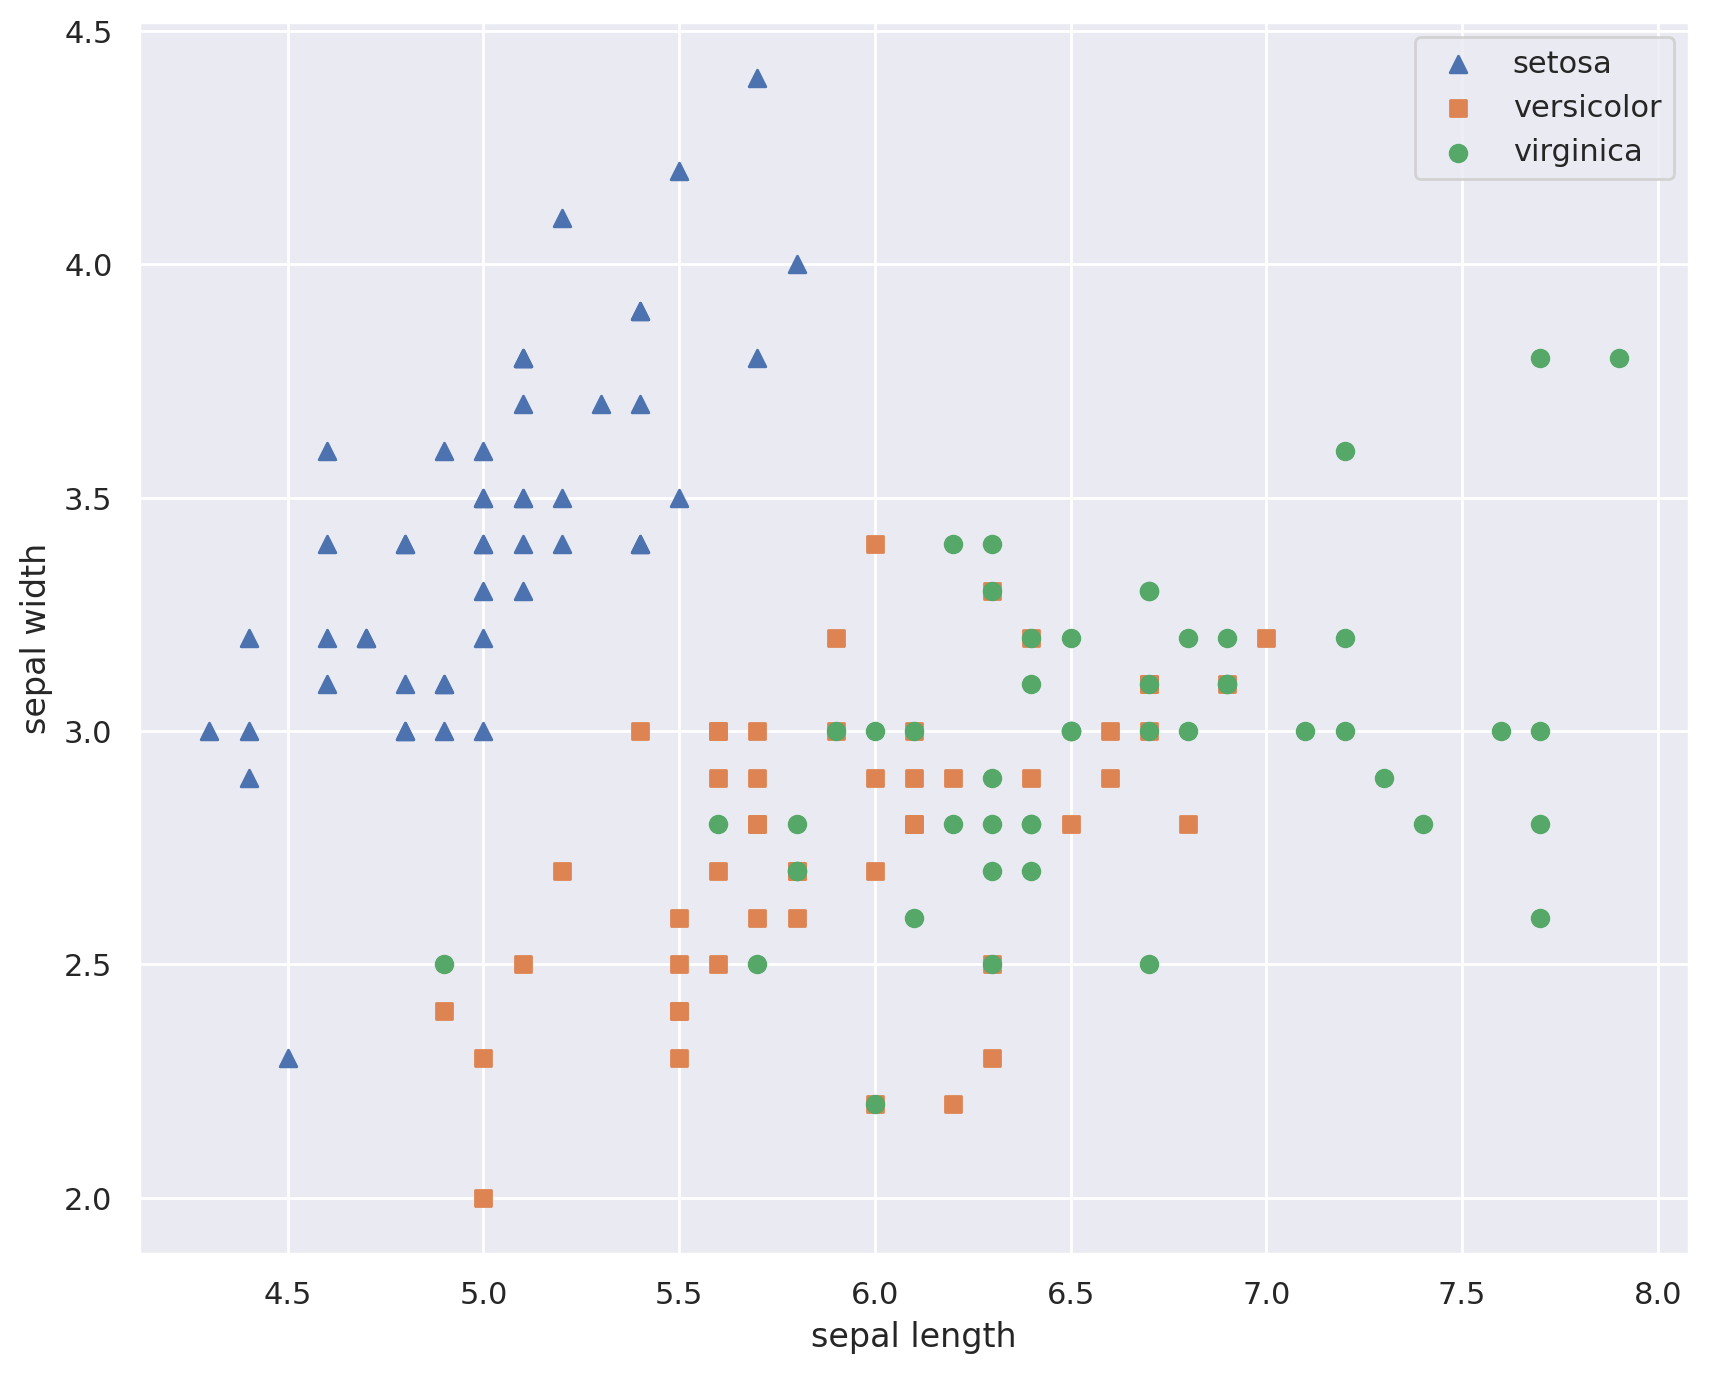

In [17]:
markers = ["^", "s", "o"]

# 0:setosa, 1:versicolor, 2:virginica
for i, marker in enumerate(markers):
    x_axis_data = iris_df[iris_df['target']==i]['sepal_length']
    y_axis_data = iris_df[iris_df['target']==i]['sepal_width']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=iris.target_names[i])

plt.legend()
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler

iris_f_scaled = StandardScaler().fit_transform(iris_df.iloc[:,:-1])

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) # of principal components = 2

pca.fit(iris_f_scaled)
iris_pca = pca.transform(iris_f_scaled)

print(f"scaled: {iris_f_scaled.shape}")
print(f"pca: {iris_pca.shape}")

scaled: (150, 4)
pca: (150, 2)


In [20]:
pca_columns=['pca_component_1','pca_component_2']

iris_df_pca = pd.DataFrame(iris_pca, columns = pca_columns)
iris_df_pca['target'] = iris.target

iris_df_pca.head(3)

,pca_component_1,pca_component_2,target
0,-2.264703,0.480027,0
1,-2.080961,-0.674134,0
2,-2.364229,-0.341908,0


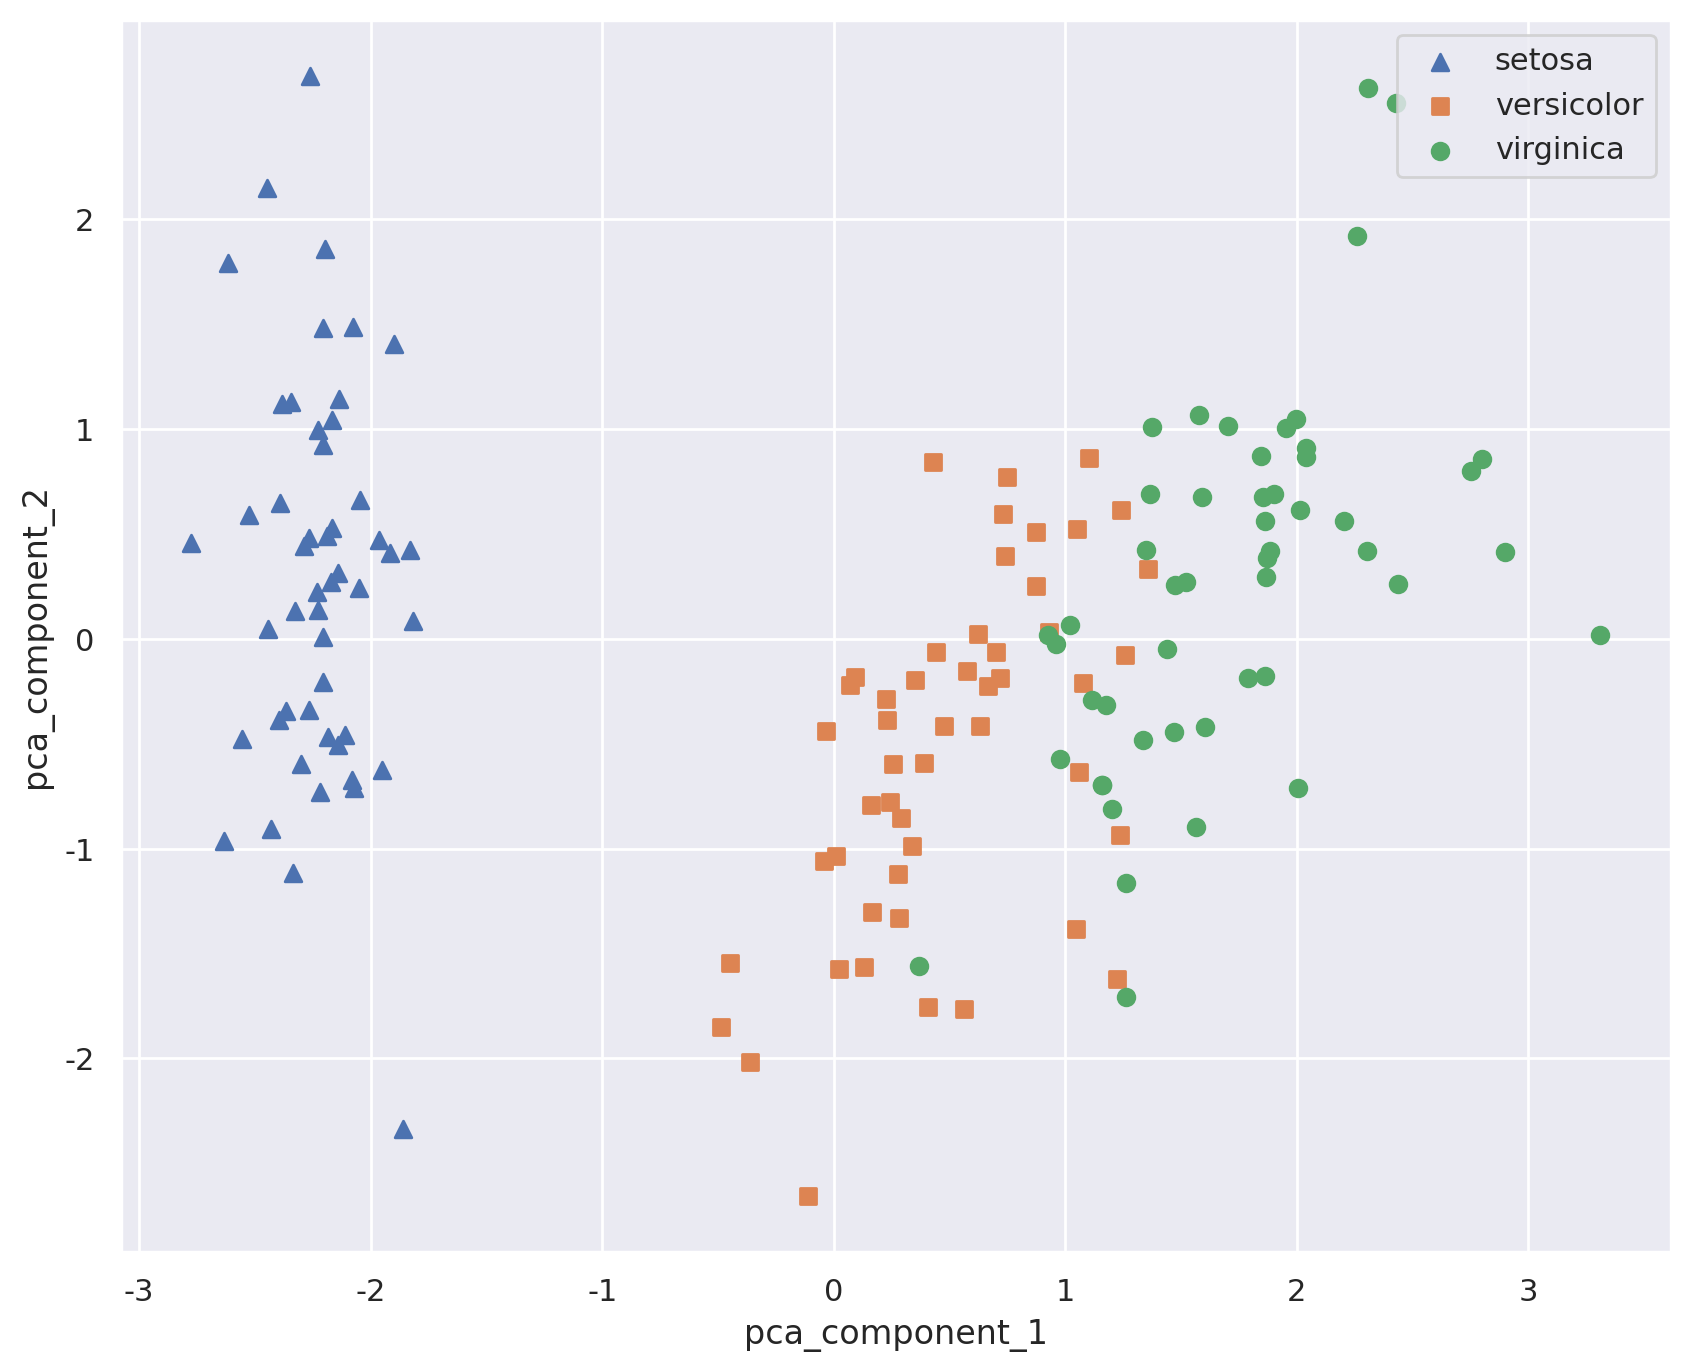

In [21]:
markers = ["^", "s", "o"]

# 0:setosa, 1:versicolor, 2:virginica
for i, marker in enumerate(markers):
    x_axis_data = iris_df_pca[iris_df_pca['target']==i]['pca_component_1']
    y_axis_data = iris_df_pca[iris_df_pca['target']==i]['pca_component_2']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=iris.target_names[i])

plt.legend()
plt.xlabel('pca_component_1')
plt.ylabel('pca_component_2')
plt.show()

In [22]:
print(pca.explained_variance_ratio_) ## Although we implemented PCA, we can still explain majority of the data

[0.72962445 0.22850762]


### Question 3.
### Autoencoder reduces the dimension of the data w/ deep learning methods.
### PCA does the same thing in mathematically linear way.
### In this context, Autoencoder is a _ _ _ _ _ _ _ _ _ PCA.
### Hint: n _ _ l _ _ _ _ _

## Autoencoder is a nonlinear PCA

## 3. Variational Autoencoder (VAE)







### Question 4 (Optional).
### Read the following document, run the whole code and write an explanation.
### https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

In [23]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [24]:
# Model Hyperparameters

dataset_path = '/content'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

### Step 1. Load Dataset

In [25]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 42011369.14it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1143825.48it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9776092.58it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10198355.87it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



## Step 2. Define model: VAE

In [26]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim) # 첫번째 인코딩 신경망
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim) # 두번째 인코딩 신경망
        self.FC_mean = nn.Linear(hidden_dim, latent_dim) # mean vector를 계산하는 코드
        self.FC_var = nn.Linear (hidden_dim, latent_dim) # variance를 계산하는 코드

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)


        return mean, log_var

In [27]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim) # 샘플링된 latent vector를 입력으로 받고 히든 레이어로 넘기는 코드
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim) # 히든 레이어 1
        self.FC_output = nn.Linear(hidden_dim, output_dim) # 결과값을 계산하는 코드

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [28]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE) # 역전파 과정에서 기울기 계산을 위해서 랜덤으로 샘플랑을 하는 것이 아닌 입력받은 분산과 비슷한 분포에서 임의의 입실론을 추출하여
        z = mean + var*epsilon                     # mean + var * epsilon을 계산한다. 이를 reparameterization trick이라고 부른다.
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x) # 인코더에서 평균과 분산을 받음
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # 평균과 분산을 이용하여 랜덤한 latent vector를 샘플링함
        x_hat = self.Decoder(z) # 샘플링한 latent vector를 디코더에 넣어 출력값을 얻음.

        return x_hat, mean, log_var

In [29]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss Function and optimizer

In [30]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train VAE

In [31]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  174.83204962372182
	Epoch 2 complete! 	Average Loss:  129.95253865491966
	Epoch 3 complete! 	Average Loss:  116.79776264477253
	Epoch 4 complete! 	Average Loss:  112.33589261725271
	Epoch 5 complete! 	Average Loss:  110.085437317404
	Epoch 6 complete! 	Average Loss:  108.6846671209829
	Epoch 7 complete! 	Average Loss:  107.4627963109088
	Epoch 8 complete! 	Average Loss:  106.48547688530363
	Epoch 9 complete! 	Average Loss:  105.66835329390129
	Epoch 10 complete! 	Average Loss:  104.91841653406719
	Epoch 11 complete! 	Average Loss:  104.36056383034224
	Epoch 12 complete! 	Average Loss:  103.94910420362062
	Epoch 13 complete! 	Average Loss:  103.59115804987479
	Epoch 14 complete! 	Average Loss:  103.1889074401346
	Epoch 15 complete! 	Average Loss:  102.85219092367487
	Epoch 16 complete! 	Average Loss:  102.5856656113053
	Epoch 17 complete! 	Average Loss:  102.29585262546954
	Epoch 18 complete! 	Average Loss:  102.12379527402442
	Ep

### Step 5. Generate images from test dataset

In [32]:
import matplotlib.pyplot as plt

In [33]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [34]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

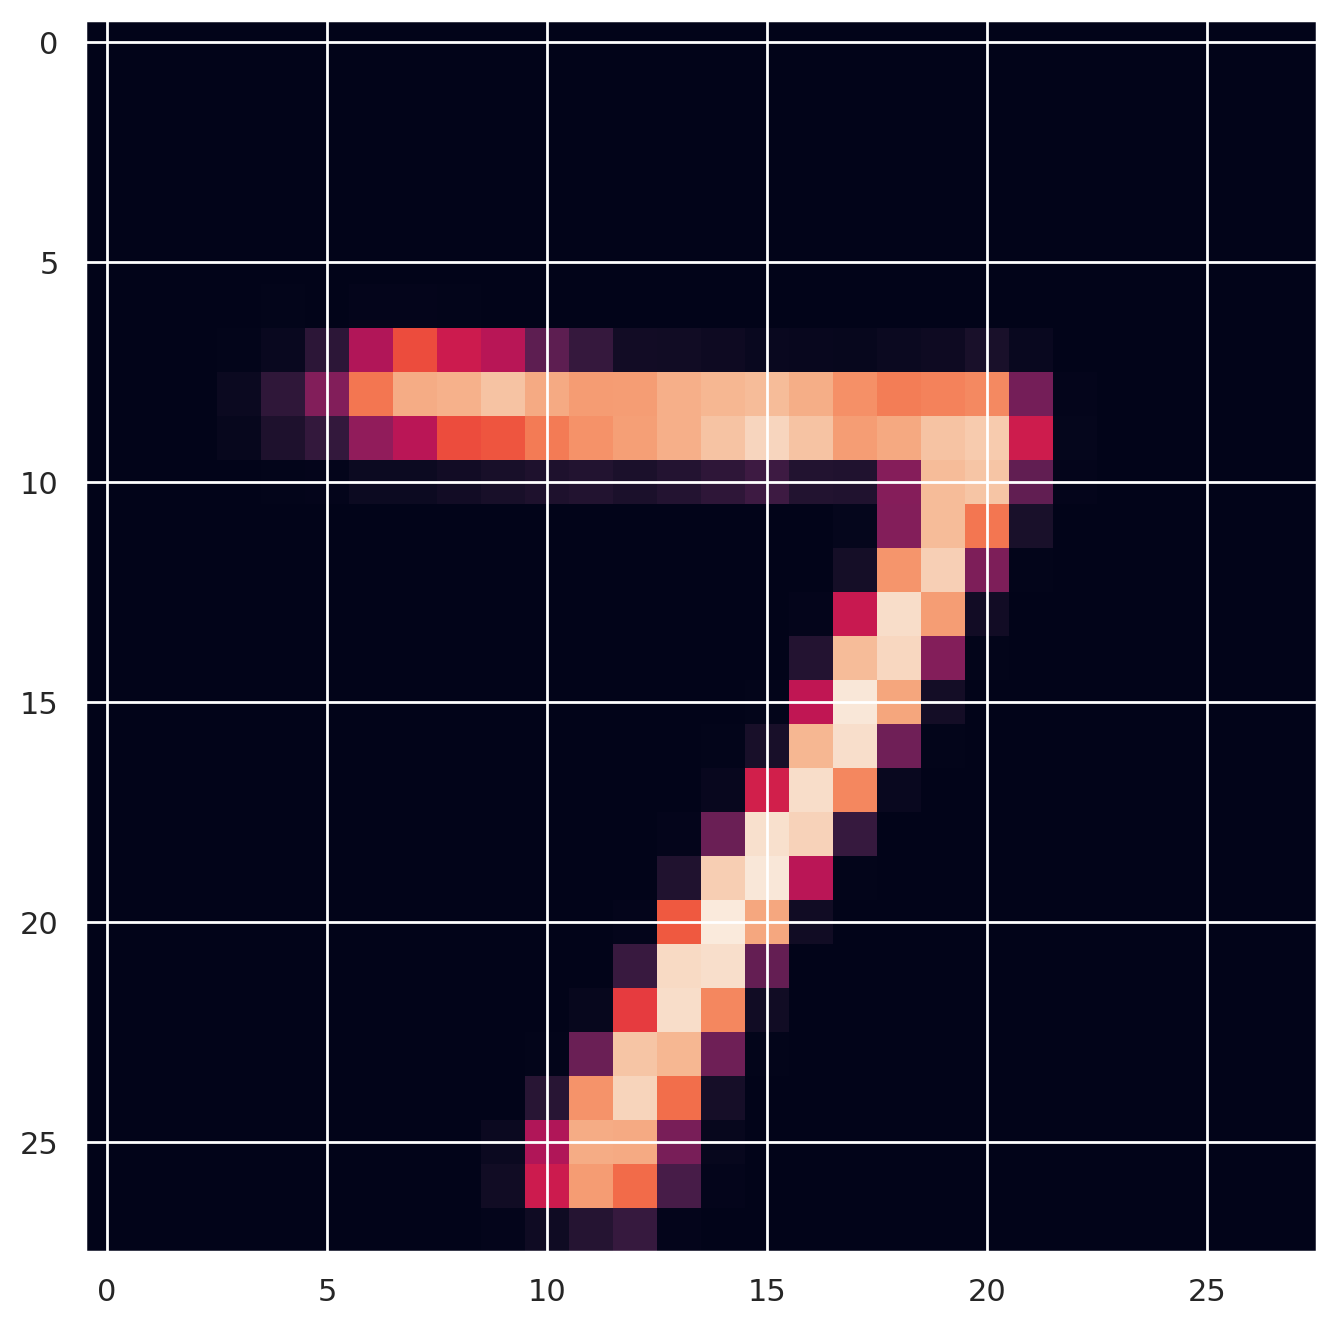

In [35]:
show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

In [36]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [37]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

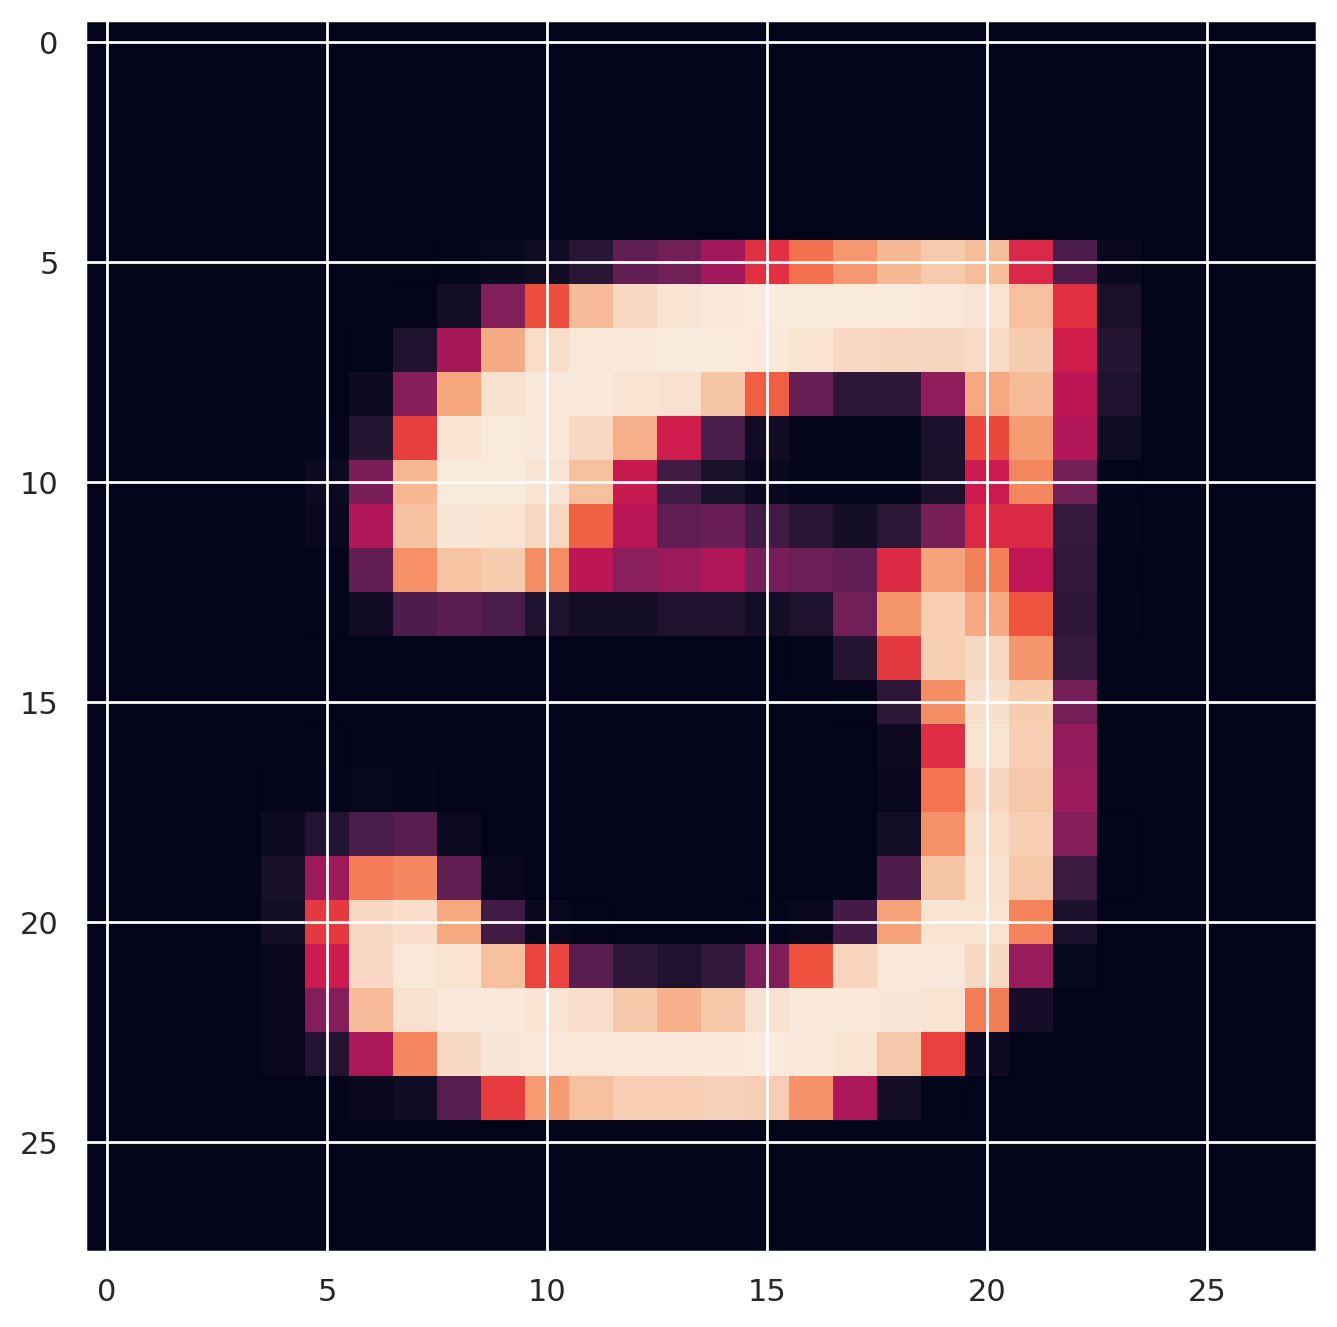

In [38]:
show_image(generated_images, idx=12)

## 4. Seq2Seq, Attention, Transformer

### Question 4 (Optional).
### Choose one of the following document. Read it, run the whole code and write and explanation.
### (1) Machine Translation using Attention and Seq2Seq: https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html
### (2) Understanding Transformer: https://wikidocs.net/156986
### (3) Chatbot based on Text Similarity (Transformer): https://wikidocs.net/157970

## (2) Understanding Transformer

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
import pandas as pd
import random
import re

from torch.utils.data import DataLoader, Dataset
# 필요한 라이브러리를 불러오는 코드

In [40]:
class PositionalEncoding(nn.Module): # Positional Encoding을 정의하기 위한 클래스
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # 드롭 아웃
        self.dropout = nn.Dropout(dropout_p)

        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)

        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])
'''
트랜스포머는 RNN이나 LSTM같은 시계열 모델과 달리 입력 시퀀스에 순서 상관없이 입력값이 한번에 들어갑니다.
하지만, 자연어처리를 하는 과정에서는 입력 데이터의 순서가 매우 중요하게 작용합니다.
따라서, 모델에 입력된 데이터의 순서 정보를 주입할 필요가 있습니다.
이를 해결하는 방법이 Positional Encoding입니다. Positional Encoding은 위치에 따라 요소에
중요도를 부여하는 방식입니다. 시퀀스의 다른 모든 요소와 관련하여 위치를 나타내는 각 요소에 대한 벡터를 생성하는 것입니다.
'''

In [41]:
class Transformer(nn.Module): # 트랜스포머를 정의하기 위한 클래스
    # Constructor
    def __init__( self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p, ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p, max_len=5000)
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src, Tgt size 는 반드시 (batch_size, src sequence length) 여야 합니다.

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model) # 인코더 입력값을 임베딩해주는 코드
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model) # 디코더 입력값을 임베딩해주는 코드
        src = self.positional_encoder(src) # 인코더 입력값을 위치 임베딩해주는 코드
        tgt = self.positional_encoder(tgt) # 디코더 입력값을 위치 임베딩해주는 코드

        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)

        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

        return mask
'''
디코더에서 첫번째 어텐션 층은 기본적인 어텐션 층이 아닌 Masked Multi-Head Attention 층이다.
Masked Multi-Head Attention에서 Mask는 디코더에서 입력값을 받을 때 뒤에 있는 값을 미리 봐서 컨닝하는 것을
막아주는 역할을 한다.
'''

    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)


In [42]:
def generate_random_data(n): # 가짜 데이터를 만드는 과정
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1,1,1,1,1,1 -> 1,1,1,1,1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0,0,0,0 -> 0,0,0,0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1,0,1,0 -> 1,0,1,0,1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

#크기가 16인 배치 형태로 만들어 줍니다.
def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # batch_size 크기가 아닌 경우 마지막 비트를 얻지 않도록 합니다.
        if idx + batch_size < len(data):
            # 여기서 배치의 최대 길이를 가져와 PAD 토큰으로 길이를 정규화해야 합니다.
            if padding:
                max_batch_length = 0
                # batch에서 가장 긴 문장 가져오기
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # 최대 길이에 도달할 때까지 X 패딩 토큰을 추가합니다.
                for seq_idx in range(batch_size):
                    remaining_length = max_bath_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))

    print(f"{len(batches)} batches of size {batch_size}")

    return batches


train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)

562 batches of size 16
187 batches of size 16


In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [44]:
def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0

    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # 이제 tgt를 1만큼 이동하여 <SOS>를 사용하여 pos 1에서 토큰을 예측합니다.
        y_input = y[:,:-1]
        y_expected = y[:,1:]

        # 다음 단어를 마스킹하려면 마스크 가져오기
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # X, y_input 및 tgt_mask를 전달하여 표준 training
        pred = model(X, y_input, tgt_mask)

        # Permute 를 수행하여 batch size 가 처음이 되도록
        pred = pred.permute(1, 2, 0)
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.detach().item()

    return total_loss / len(dataloader)

In [45]:
def validation_loop(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            y_input = y[:,:-1]
            y_expected = y[:,1:]

            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            pred = model(X, y_input, tgt_mask)

            pred = pred.permute(1, 2, 0)
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()

    return total_loss / len(dataloader)

In [46]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    # 나중에 plotting 하기위해
    train_loss_list, validation_loss_list = [], []

    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)

        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]

        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]

        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()

    return train_loss_list, validation_loss_list

train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 10)

Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 0.5485
Validation loss: 0.4079

------------------------- Epoch 2 -------------------------
Training loss: 0.4066
Validation loss: 0.3659

------------------------- Epoch 3 -------------------------
Training loss: 0.3730
Validation loss: 0.3265

------------------------- Epoch 4 -------------------------
Training loss: 0.3411
Validation loss: 0.2870

------------------------- Epoch 5 -------------------------
Training loss: 0.3112
Validation loss: 0.2514

------------------------- Epoch 6 -------------------------
Training loss: 0.2878
Validation loss: 0.2208

------------------------- Epoch 7 -------------------------
Training loss: 0.2695
Validation loss: 0.2034

------------------------- Epoch 8 -------------------------
Training loss: 0.2564
Validation loss: 0.1854

------------------------- Epoch 9 -------------------------
Training loss: 0.2451
Validation loss: 0.1785

-------

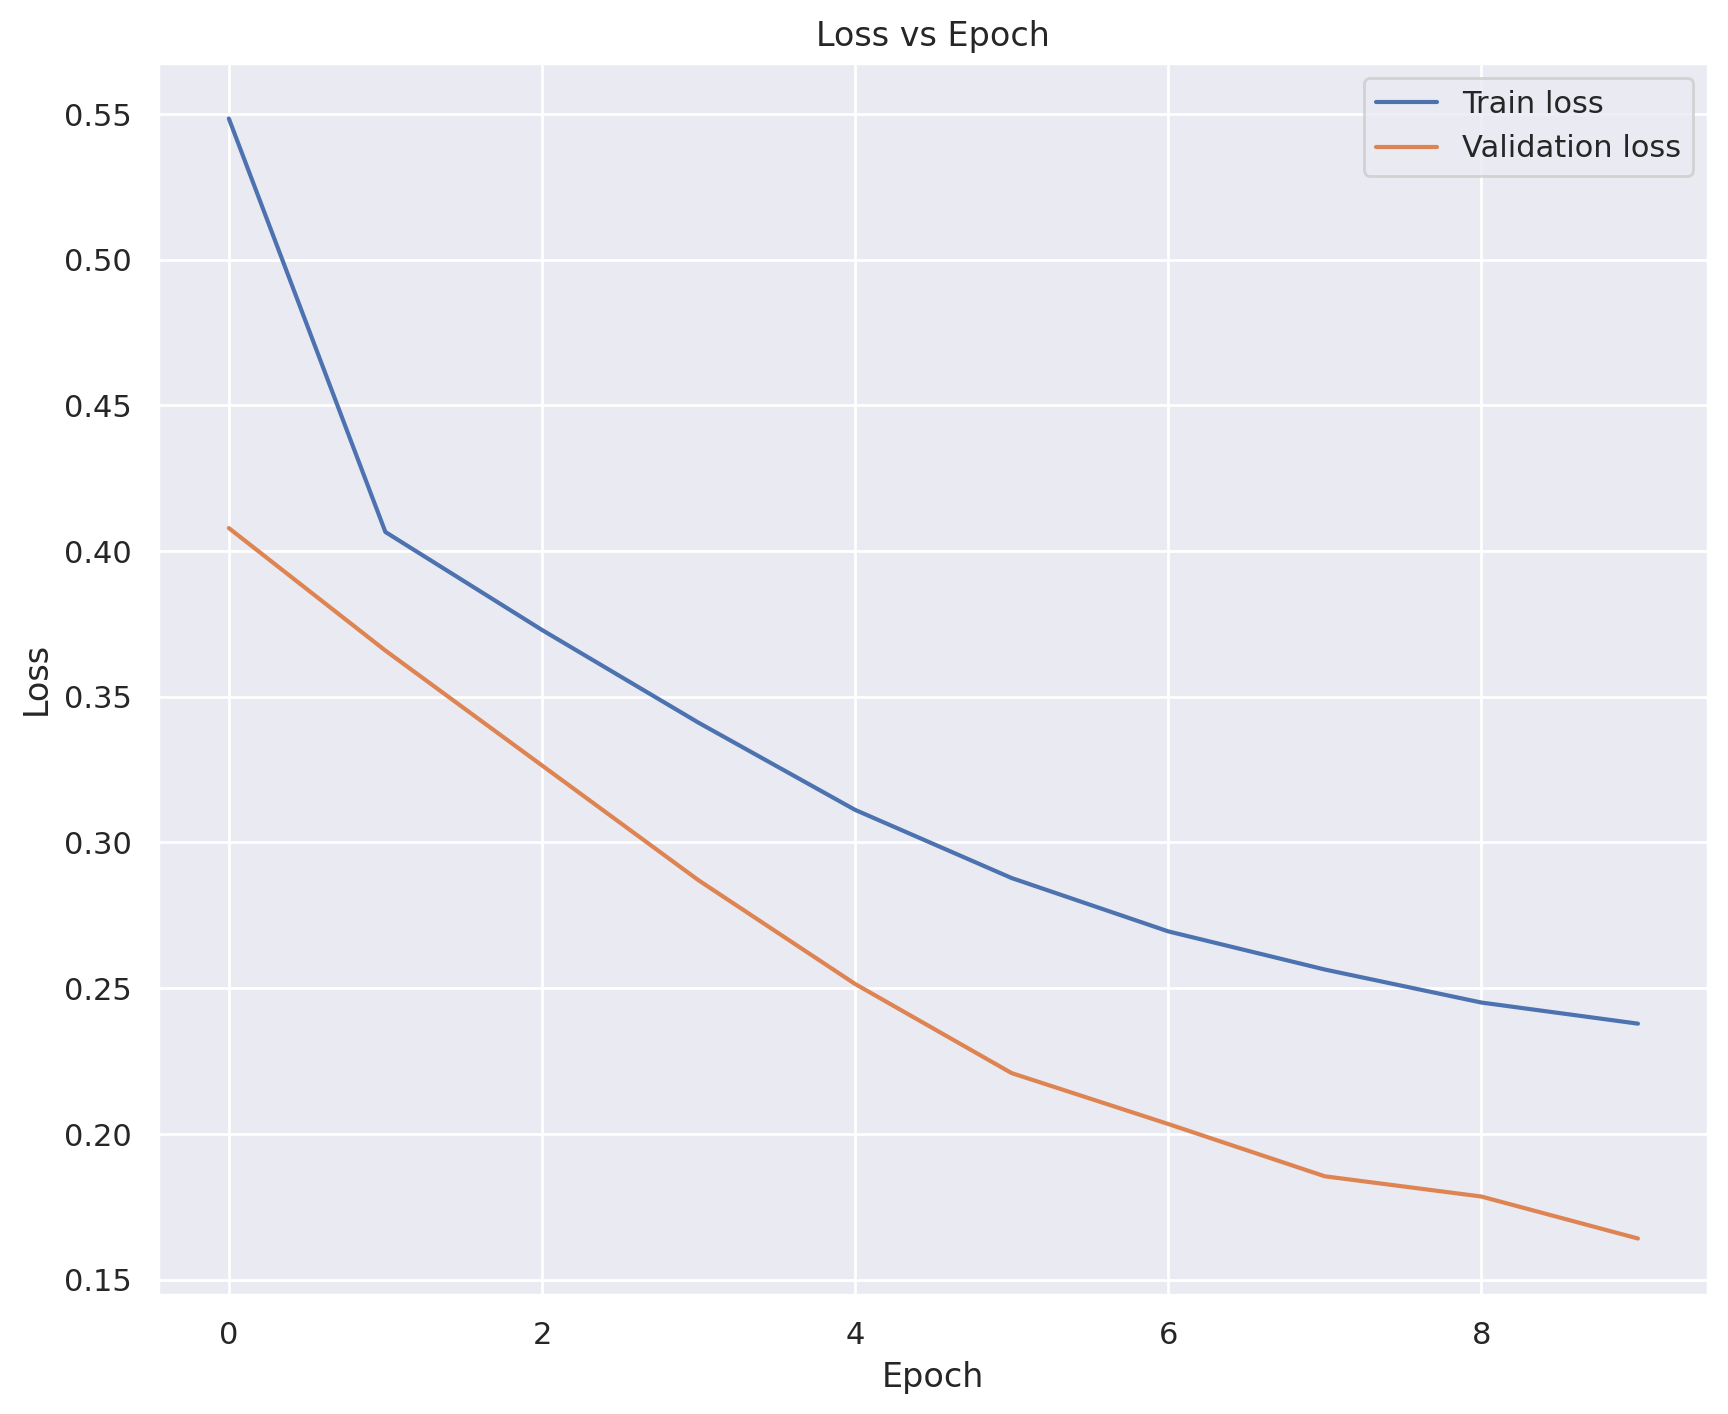

In [47]:
plt.plot(train_loss_list, label = "Train loss")
plt.plot(validation_loss_list, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [48]:
def predict(model, input_sequence, max_length=15, SOS_token=2, EOS_token=3):
    model.eval()

    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)

        pred = model(input_sequence, y_input, tgt_mask)

        next_item = pred.topk(1)[1].view(-1)[-1].item() # num with highest probability
        next_item = torch.tensor([[next_item]], device=device)

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if model predicts end of sentence
        if next_item.view(-1).item() == EOS_token:
            break

    return y_input.view(-1).tolist()


# Here we test some examples to observe how the model predicts
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 3]], dtype=torch.long, device=device)
]

for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")
    print(f"Continuation: {result[1:-1]}")
    print()

Example 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1]

Example 3
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1]

Example 4
Input: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 5
Input: [0, 1]
Continuation: [0, 1, 0, 1, 0, 1, 0]



### The End.

##### Please upload your Colab file @Github https://github.com/duneag2/intro-dl/tree/main/Assignment8

*   First, make your folder by your name (e.g. seungeun)
*   Then upload your "Jupyter Notebook" file under that directory

###### Need Help?



*   Please refer to this link https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-colab%EC%BD%94%EB%9E%A9%EC%97%90%EC%84%9C-%EC%95%95%EC%B6%95%ED%8C%8C%EC%9D%BC-%ED%92%80%EA%B8%B0 OR
*   Just save your Jupyter Notebook (.ipynb) file in here (colab) and upload via 'Add file' - 'Upload files' https://nthree.tistory.com/60